# Nourishing Numbers: The Impact of Nutritional Value and Recipe Steps on Food Ratings and Reviews

**Name(s)**: Aniket Bhosale and Selina Wu

**Website Link**: [Nourishing Numbers](https://bhosaleaniket.github.io/Nourishing-Numbers/)

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path

import plotly.express as px
pd.options.plotting.backend = 'plotly'
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
import plotly.graph_objects as go
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix


from dsc80_utils import * # Feel free to uncomment and use this.
pd.set_option('display.max_rows', 100)

## Step 1: Introduction

In [2]:
# recipies_df = pd.read_csv('data\RAW_recipes.csv') # import the  recipies data
# ratings_df = pd.read_csv('data\RAW_interactions.csv') # import the ratings data
interactions_fp = Path('food_data')/'RAW_interactions.csv'
ratings_df = pd.read_csv(interactions_fp)


recipes_fp = Path('food_data') / 'Raw_recipes.csv'
recipies_df = pd.read_csv(recipes_fp)

## Step 2: Data Cleaning and Exploratory Data Analysis

### Data Cleaning

In [3]:
df = pd.merge(recipies_df, ratings_df, left_on='id', right_on='recipe_id', how = 'left' ) # merge the two dataframes
df = df.dropna(subset=['recipe_id']) # drop rows where recipe_id is NaN
df['rating'] = df['rating'].apply(lambda x: np.nan if x == 0 else x) # replace the 0 rating with NaN values since ratings range from 1 to 5
df['average rating per recipe'] = df[['recipe_id','rating']].groupby('recipe_id').transform('mean') # calculate the average rating per recipe
df = df.drop(columns = 'id') # drop the id column since it is a duplicate of the recipe_id column
df

name  minutes  contributor_id  \
0               1 brownies in the world    best ever       40          985201   
1                 1 in canada chocolate chip cookies       45         1848091   
2                             412 broccoli casserole       40           50969   
3                             412 broccoli casserole       40           50969   
4                             412 broccoli casserole       40           50969   
...                                              ...      ...             ...   
234424                     zydeco ya ya deviled eggs       40           37779   
234425        cookies by design   cookies on a stick       29          506822   
234426  cookies by design   sugar shortbread cookies       20          506822   
234427  cookies by design   sugar shortbread cookies       20          506822   
234428  cookies by design   sugar shortbread cookies       20          506822   

         submitted  ...        date rating  \
0       2008-10-27  ...  2008-11-19    4.0   
1       2011-04-11  ...  2012-01-26    5.0   
2       2008-05-30  ...  2008-12-31    5.0   
3       2008-05-30  ...  2009-04-13    5.0   
4       2008-05-30  ...  2013-08-02    5.0   
...            ...  ...         ...    ...   
234424  2008-06-07  ...  2009-10-14    5.0   
234425  2008-04-15  ...  2008-05-02    1.0   
234426  2008-04-15  ...  2008-06-19    1.0   
234427  2008-04-15  ...  2010-02-08    5.0   
234428  2008-04-15  ...  2014-11-01    NaN   

                                                   review  \
0       These were pretty good, but took forever to ba...   
1       Originally I was gonna cut the recipe in half ...   
2       This was one of the best broccoli casseroles t...   
3       I made this for my son's first birthday party ...   
4       Loved this.  Be sure to completely thaw the br...   
...                                                   ...   
234424  These were very good. I meant to add some jala...   
234425  I would rate this a zero if I could. I followe...   
234426  This recipe tastes nothing like the Cookies by...   
234427  yummy cookies, i love this recipe me and my sm...   
234428  I work at a Cookies By Design and can say this...   

       average rating per recipe  
0                            4.0  
1                            5.0  
2                            5.0  
3                            5.0  
4                            5.0  
...                          ...  
234424                       5.0  
234425                       1.0  
234426                       3.0  
234427                       3.0  
234428                       3.0  

[234428 rows x 17 columns]

In [4]:
df['submitted'] = pd.to_datetime(df['submitted']) # convert the submitted column to datetime
df['date'] = pd.to_datetime(df['date']) # convert the date column to datetime

In [5]:
# Assuming 'list_column' is the name of the column that contains the list
df[['calories (#)', 'total fat (PDV)', 'sugar (PDV)', 'sodium (PDV)', 'protein (PDV)', 'saturated fat (PDV)', 'carbohydrates (PDV)']] = df['nutrition'].apply(lambda x: list(x.strip('[]').split(','))).apply(pd.Series) # split the nutrition column into separate columns
df = df.drop(columns = ['nutrition']) # drop the nutrition column since it is no longer needed
columns_to_convert = ['calories (#)','total fat (PDV)', 'sugar (PDV)', 'sodium (PDV)', 'protein (PDV)', 'saturated fat (PDV)', 'carbohydrates (PDV)']
for column in columns_to_convert:
    df[column] = df[column].astype(float)
df.head()

name  minutes  contributor_id  submitted  \
0  1 brownies in the world    best ever       40          985201 2008-10-27   
1    1 in canada chocolate chip cookies       45         1848091 2011-04-11   
2                412 broccoli casserole       40           50969 2008-05-30   
3                412 broccoli casserole       40           50969 2008-05-30   
4                412 broccoli casserole       40           50969 2008-05-30   

   ... sodium (PDV)  protein (PDV) saturated fat (PDV) carbohydrates (PDV)  
0  ...          3.0            3.0                19.0                 6.0  
1  ...         22.0           13.0                51.0                26.0  
2  ...         32.0           22.0                36.0                 3.0  
3  ...         32.0           22.0                36.0                 3.0  
4  ...         32.0           22.0                36.0                 3.0  

[5 rows x 23 columns]

### Univariate Analysis

In [6]:
cook_time = df.drop_duplicates(subset = 'recipe_id')
print(cook_time['minutes'].describe())
cook_time = cook_time['minutes']

bins = np.logspace(np.log10(1), np.log10(cook_time.max()), 50) # 1 as the minimum value since np.log10(0) is undefined

# Use np.histogram to calculate the counts in each bin
counts, bin_edges = np.histogram(cook_time, bins=bins, density=True)

# Create the histogram using plotly.graph_objects
fig = go.Figure(data=go.Bar(x=bin_edges[:-1], y=counts, width=np.diff(bin_edges)))
fig.update_layout(title='Cook Time Distribution', xaxis_title='Cook Time (log scale)', yaxis_title='Proportion')
fig.update_xaxes(type='log')  # Set x-axis to logarithmic scale
fig.show()

count    8.38e+04
mean     1.15e+02
std      3.99e+03
min      0.00e+00
25%      2.00e+01
50%      3.50e+01
75%      6.50e+01
max      1.05e+06
Name: minutes, dtype: float64


In [7]:
num_steps = df.drop_duplicates(subset = 'recipe_id')
num_steps = num_steps['n_steps']
print(num_steps.describe())
fig = px.histogram(num_steps, nbins = 50, title = 'Number of Steps Distribution', histnorm='probability')
fig.update_xaxes(title_text = 'Number of Steps')
fig.update_yaxes(title_text = 'Proportion')
fig.show()

count    83781.00
mean        10.11
std          6.39
min          1.00
25%          6.00
50%          9.00
75%         13.00
max        100.00
Name: n_steps, dtype: float64


In [8]:
ratings = df.drop_duplicates(subset = 'recipe_id')
ratings = ratings['average rating per recipe']
print(ratings.describe())
fig = px.histogram(ratings, nbins = 5, title = 'Average Rating Distribution', histnorm='probability')
fig.update_xaxes(title_text = 'Average Rating')
fig.update_yaxes(title_text = 'Proportion')
fig.show()

count    81173.00
mean         4.63
std          0.64
min          1.00
25%          4.50
50%          5.00
75%          5.00
max          5.00
Name: average rating per recipe, dtype: float64


In [9]:
review_length = df.dropna(subset = ['recipe_id', 'review'])
review_length = review_length['review'].apply(lambda x: len(x))
print(review_length.describe())
fig = px.histogram(review_length, nbins = 50, title = 'Review Length Distribution', histnorm='probability')
fig.update_xaxes(title_text = 'Review Length')
fig.update_yaxes(title_text = 'Proportion')
fig.show()

count    234371.00
mean        289.44
std         203.01
min           1.00
25%         152.00
50%         249.00
75%         375.00
max        5799.00
Name: review, dtype: float64


In [10]:
fat = df.drop_duplicates(subset = 'recipe_id')
fat = fat['total fat (PDV)']
print(fat.describe())
fig = px.histogram(fat, nbins = 100, title = 'Total Fat Distribution', histnorm='probability')
fig.update_xaxes(title_text = 'Total Fat')
fig.update_yaxes(title_text = 'Proportion')
fig.show()



count    83781.00
mean        32.62
std         60.15
min          0.00
25%          8.00
50%         20.00
75%         39.00
max       3464.00
Name: total fat (PDV), dtype: float64


In [11]:
sugar = df.drop_duplicates(subset = 'recipe_id')
sugar = sugar['sugar (PDV)']
print(sugar.describe())
fig = px.histogram(sugar, nbins = 100, title = 'Sugar Distribution', histnorm='probability')
fig.update_xaxes(title_text = 'Sugar')
fig.update_yaxes(title_text = 'Proportion')
fig.show()


count    83781.00
mean        68.67
std        247.24
min          0.00
25%          9.00
50%         23.00
75%         61.00
max      30260.00
Name: sugar (PDV), dtype: float64


In [12]:
sodium = df.drop_duplicates(subset = 'recipe_id')
sodium = sodium['sodium (PDV)']
print(sodium.describe())
fig = px.histogram(sodium, nbins = 100, title = 'Sodium Distribution', histnorm='probability')
fig.update_xaxes(title_text = 'Sodium')
fig.update_yaxes(title_text = 'Proportion')
fig.show()


count    83781.00
mean        28.94
std        144.98
min          0.00
25%          5.00
50%         14.00
75%         32.00
max      29338.00
Name: sodium (PDV), dtype: float64


In [13]:
protein = df.drop_duplicates(subset = 'recipe_id')
protein = protein['protein (PDV)']
print(protein.describe())
fig = px.histogram(protein, nbins = 100, title = 'Protein Distribution', histnorm='probability')
fig.update_xaxes(title_text = 'Protein')
fig.update_yaxes(title_text = 'Proportion')
fig.show()


count    83781.00
mean        33.13
std         51.03
min          0.00
25%          6.00
50%         18.00
75%         49.00
max       4356.00
Name: protein (PDV), dtype: float64


In [14]:
saturated_fat = df.drop_duplicates(subset = 'recipe_id')
saturated_fat = saturated_fat['saturated fat (PDV)']
print(saturated_fat.describe())
fig = px.histogram(saturated_fat, nbins = 100, title = 'Saturated Fat Distribution', histnorm='probability')
fig.update_xaxes(title_text = 'Saturated Fat')
fig.update_yaxes(title_text = 'Proportion')
fig.show()


count    83781.00
mean        40.24
std         80.91
min          0.00
25%          6.00
50%         21.00
75%         49.00
max       6875.00
Name: saturated fat (PDV), dtype: float64


In [15]:
carbohydrates = df.drop_duplicates(subset = 'recipe_id')
carbohydrates = carbohydrates['carbohydrates (PDV)']
print(carbohydrates.describe())
fig = px.histogram(carbohydrates, nbins = 100, title = 'Carbohydrates Distribution', histnorm='probability')
fig.update_xaxes(title_text = 'Carbohydrates')
fig.update_yaxes(title_text = 'Proportion')
fig.show()


count    83781.00
mean        13.79
std         28.76
min          0.00
25%          4.00
50%          9.00
75%         16.00
max       3007.00
Name: carbohydrates (PDV), dtype: float64


### Bivariate Analysis

In [16]:
filtered_df = df.drop_duplicates(subset = 'recipe_id') # most recipe related columns are the same for each recipe_id so we can drop duplicates
filtered_df.columns

Index(['name', 'minutes', 'contributor_id', 'submitted', 'tags', 'n_steps',
       'steps', 'description', 'ingredients', 'n_ingredients', 'user_id',
       'recipe_id', 'date', 'rating', 'review', 'average rating per recipe',
       'calories (#)', 'total fat (PDV)', 'sugar (PDV)', 'sodium (PDV)',
       'protein (PDV)', 'saturated fat (PDV)', 'carbohydrates (PDV)'],
      dtype='object')

In [17]:
avg_steps_per_rating = filtered_df.groupby('rating')['n_steps'].mean().reset_index()

# Plot the data
fig = px.bar(avg_steps_per_rating, x='rating', y='n_steps', title='Average Number of Steps vs Rating')
fig.update_xaxes(title_text='Rating')
fig.update_yaxes(title_text='Average Number of Steps')
fig.show()

In [18]:
avg_steps_per_rating = filtered_df.groupby('rating')['minutes'].mean().reset_index()

# Plot the data
fig = px.bar(avg_steps_per_rating, x='rating', y='minutes', title='Rating vs Average Number of Steps')
fig.update_xaxes(title_text='Rating')
fig.update_yaxes(title_text='Average Number of Steps')
fig.show()

In [19]:
df_w_len = df.dropna(subset = ['recipe_id', 'review'])
df_w_len['review_length'] = df_w_len['review'].apply(lambda x: len(x))
avg_review_length_per_cook_time = df_w_len.groupby('minutes')['review_length'].mean().reset_index()

# Calculate the IQR for 'review_length'
Q1 = avg_review_length_per_cook_time['minutes'].quantile(0.25)
Q3 = avg_review_length_per_cook_time['minutes'].quantile(0.75)
IQR = Q3 - Q1

# Define the upper and lower bounds for the IQR
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter the DataFrame to only include rows within the IQR
filtered_avg_review_length_per_cook_time = avg_review_length_per_cook_time[(avg_review_length_per_cook_time['minutes'] >= lower_bound) & 
                                                                           (avg_review_length_per_cook_time['minutes'] <= upper_bound)]

# Plot the data
fig = px.scatter(filtered_avg_review_length_per_cook_time, x='minutes', y='review_length', title='Cook Time vs Average Review Length')
fig.update_xaxes(title_text='Cook Time')
fig.update_yaxes(title_text='Average Review Length')
fig.show()

In [20]:
df_w_len = df.dropna(subset = ['recipe_id', 'review'])
df_w_len['review_length'] = df_w_len['review'].apply(lambda x: len(x))
avg_review_length_per_rating = df_w_len.groupby('n_steps')['review_length'].mean().reset_index()

# Plot the data
fig = px.scatter(avg_review_length_per_rating, x='n_steps', y='review_length', title='Number of Steps vs Average Review Length')
fig.update_xaxes(title_text='Number of Steps')
fig.update_yaxes(title_text='Average Review Length')
fig.show()


In [21]:
avg_calories_per_rating = filtered_df.groupby('rating')['calories (#)'].mean().reset_index()

# Plot the data
fig = px.bar(avg_calories_per_rating, x='rating', y='calories (#)', title='Rating vs Average Calories')
fig.update_xaxes(title_text='Rating')
fig.update_yaxes(title_text='Average Calories')
fig.show()

In [22]:
avg_saturated_fat_per_rating = df.groupby('rating')['saturated fat (PDV)'].mean().reset_index()

# Plot the data
fig = px.bar(avg_saturated_fat_per_rating, x='rating', y='saturated fat (PDV)', title='Rating vs Average Saturated Fat')
fig.update_xaxes(title_text='Rating')
fig.update_yaxes(title_text='Average Saturated Fat')
fig.show()

In [23]:
avg_sugar_per_rating = df.groupby('rating')['sugar (PDV)'].mean().reset_index()

# Plot the data
fig = px.bar(avg_sugar_per_rating, x='rating', y='sugar (PDV)', title='Rating vs Average Sugar')
fig.update_xaxes(title_text='Rating')
fig.update_yaxes(title_text='Average Sugar')
fig.show()

In [24]:
avg_protein_per_rating = df.groupby('rating')['protein (PDV)'].mean().reset_index()

# Plot the data
fig = px.bar(avg_protein_per_rating, x='rating', y='protein (PDV)', title='Rating vs Average Protein')
fig.update_xaxes(title_text='Rating')
fig.update_yaxes(title_text='Average Protein')
fig.show()

### Interesting Aggregates

In [25]:
new_df = filtered_df.pivot_table(index='rating', values=['calories (#)', 'total fat (PDV)', 'sugar (PDV)', 'sodium (PDV)', 'protein (PDV)', 'saturated fat (PDV)', 'carbohydrates (PDV)'], aggfunc='mean')

In [26]:
df.pivot_table(index='rating', values = 'minutes', aggfunc=['min','median','mean','max'])

min  median    mean      max
       minutes minutes minutes  minutes
rating                                 
1.0          1      40   99.67    20190
2.0          1      40   98.02    14400
3.0          1      40   87.50    43200
4.0          1      35   91.59   288000
5.0          0      35  106.92  1051200

In [27]:
df.pivot_table(index = 'n_steps', values = 'rating', aggfunc = ['min','median','mean','max'])

min median   mean    max
        rating rating rating rating
n_steps                            
1          1.0    5.0   4.72    5.0
2          1.0    5.0   4.72    5.0
3          1.0    5.0   4.71    5.0
4          1.0    5.0   4.70    5.0
5          1.0    5.0   4.66    5.0
6          1.0    5.0   4.67    5.0
7          1.0    5.0   4.68    5.0
8          1.0    5.0   4.67    5.0
9          1.0    5.0   4.67    5.0
10         1.0    5.0   4.66    5.0
11         1.0    5.0   4.67    5.0
12         1.0    5.0   4.67    5.0
13         1.0    5.0   4.69    5.0
14         1.0    5.0   4.67    5.0
15         1.0    5.0   4.68    5.0
16         1.0    5.0   4.69    5.0
17         1.0    5.0   4.70    5.0
18         1.0    5.0   4.67    5.0
19         1.0    5.0   4.69    5.0
20         1.0    5.0   4.71    5.0
21         1.0    5.0   4.69    5.0
22         1.0    5.0   4.68    5.0
23         1.0    5.0   4.70    5.0
24         1.0    5.0   4.71    5.0
25         1.0    5.0   4.60    5.0
26         1.0    5.0   4.65    5.0
27         1.0    5.0   4.63    5.0
28         1.0    5.0   4.84    5.0
29         1.0    5.0   4.76    5.0
30         1.0    5.0   4.63    5.0
31         1.0    5.0   4.60    5.0
32         1.0    5.0   4.65    5.0
33         1.0    5.0   4.76    5.0
34         1.0    5.0   4.70    5.0
35         1.0    5.0   4.70    5.0
36         1.0    5.0   4.63    5.0
37         1.0    5.0   4.63    5.0
38         1.0    5.0   4.66    5.0
39         2.0    5.0   4.78    5.0
40         3.0    5.0   4.81    5.0
41         1.0    5.0   4.69    5.0
42         1.0    5.0   4.70    5.0
43         5.0    5.0   5.00    5.0
44         1.0    5.0   4.56    5.0
45         1.0    5.0   4.64    5.0
46         1.0    5.0   4.53    5.0
47         2.0    5.0   4.83    5.0
48         2.0    5.0   4.82    5.0
49         1.0    5.0   4.59    5.0
50         3.0    5.0   4.87    5.0
51         1.0    5.0   4.37    5.0
52         3.0    5.0   4.40    5.0
53         3.0    5.0   4.73    5.0
54         5.0    5.0   5.00    5.0
55         1.0    5.0   4.53    5.0
56         5.0    5.0   5.00    5.0
57         3.0    5.0   4.82    5.0
58         3.0    5.0   4.86    5.0
59         5.0    5.0   5.00    5.0
60         5.0    5.0   5.00    5.0
61         2.0    5.0   4.50    5.0
62         4.0    5.0   4.75    5.0
63         5.0    5.0   5.00    5.0
64         5.0    5.0   5.00    5.0
65         5.0    5.0   5.00    5.0
66         5.0    5.0   5.00    5.0
67         5.0    5.0   5.00    5.0
68         4.0    4.5   4.50    5.0
69         5.0    5.0   5.00    5.0
70         5.0    5.0   5.00    5.0
73         5.0    5.0   5.00    5.0
76         5.0    5.0   5.00    5.0
77         5.0    5.0   5.00    5.0
79         4.0    5.0   4.75    5.0
80         4.0    5.0   4.88    5.0
81         4.0    4.5   4.50    5.0
85         5.0    5.0   5.00    5.0
86         5.0    5.0   5.00    5.0
87         5.0    5.0   5.00    5.0
88         3.0    4.0   4.14    5.0
93         5.0    5.0   5.00    5.0
98         5.0    5.0   5.00    5.0
100        5.0    5.0   5.00    5.0

In [28]:
df.pivot_table(index='n_steps', values = 'minutes', aggfunc=['min','median','mean','max'])

min  median     mean      max
        minutes minutes  minutes  minutes
n_steps                                  
1             0     5.0    22.20     7440
2             1     6.0    38.42     4335
3             1    10.0    46.47    10100
4             1    20.0    72.68    43202
5             1    22.0    94.82    30240
6             1    30.0    68.76    43215
7             1    30.0    77.41    86415
8             1    35.0    76.66    20165
9             1    35.0   208.27  1051200
10            1    40.0    73.80    72000
11            2    40.0    76.90    43215
12            2    44.0   111.01   288000
13            2    45.0   101.14    43200
14            2    45.0    88.14    53290
15            2    50.0    95.48    14400
16            2    49.0   411.61    20190
17            2    50.0   105.59    41775
18            2    50.0   162.58    60510
19            1    55.0   140.09    40410
20            2    60.0    99.20    30270
21            5    55.0    98.13    10080
22            2    72.0   162.92    14600
23            2    60.0   177.16    43200
24            5    60.0   143.61     4560
25            7    75.0   166.01    43380
26            7    71.0   593.09     4340
27            2    75.0   202.17     7200
28           10    75.0   123.22     2925
29           20    85.0   138.01    10140
30            2    70.0   142.39     4500
31           12    70.0   130.73     1650
32            5    77.5   236.26    15880
33            5    75.0   251.01    14460
34           10    60.0   203.75     1740
35           10   105.0   247.79     3000
36           25    90.0   223.54     1448
37           15    65.0   135.52      915
38            4    75.0   145.54     1485
39           15   140.0   172.93      945
40           35    95.0   155.43     1475
41           10   210.0   263.24     2920
42           15   110.0   150.78     1462
43           35    85.0   168.50     1560
44            5   135.0   194.32     1220
45           30   260.0   339.81    16200
46           60   135.0   134.37      400
47           40   285.0   439.36     1620
48            6    75.0   100.90      360
49            1   125.0   382.62     2925
50           38    60.0    88.09      240
51           30   330.0   588.93     2915
52           40   150.0   128.75      150
53           50   120.0   160.67      780
54           50    60.0   154.77      390
55           50   100.0   121.71      340
56           75   240.0   190.00      255
57           44    44.0    99.75      320
58           45   140.0   222.06      675
59           75    90.0    99.00      150
60            5   125.0    94.14      125
61           40    40.0    53.68      210
62          105   165.0   703.00     2900
63           15   180.0   165.00      270
64         2940  2940.0  2940.00     2940
65           90    90.0    90.00       90
66           60   495.0   408.00      495
67           23  1481.5  1481.50     2940
68           42    42.0    42.00       42
69          150   150.0   150.00      150
70           60    60.0   178.33     1125
71          400   400.0   400.00      400
73           15    87.5    87.50      160
76           35    91.0   897.57     2970
77           60    60.0    60.00       60
79          830   830.0   830.00      830
80           60    60.0    60.00       60
81          510  2925.0  2340.00     3000
85          860   860.0   860.00      860
86           18    18.0    18.00       18
87          195   195.0   195.00      195
88          180  2880.0  2610.00     2880
93          360   360.0   360.00      360
98         2930  2930.0  2930.00     2930
100        1680  1680.0  1680.00     1680

In [29]:
html_table = new_df.to_html(classes = 'table table-striped', border=0)
with open('new_table.html', 'w') as file:
    file.write(html_table)

## Step 3: Assessment of Missingness

### NMAR Analysis

In [90]:
df.isna().sum()
#columns with any missing values:
#description, review, review_len, rating, name
#the name column only has one missing value, which we decided was MCAR and not large enough to be meaningful.
#To test for NMAR missingness, I compared means and medians of data between rows with missing values of one 
#category vs rows without missing values of the same category. 

rev_na = df[df['review'].isna()]
rev_na['minutes'].median() #40.0
df['minutes'].median() #35.0
rev_na['n_steps'].mean() #15.43859649122807
df['n_steps'].mean() #9.931975951830733
#missingness of review tends to be greater for longer recipes (more steps, longer time taken)
#review does not seem to be NMAR
#review_len depends on review being na so MAR on review

desc_na = df[df['description'].isna()]
desc_na['calories (#)'].mean() #301.91238095238094
df['calories (#)'].mean() #415.10282780216323
#tends to be missing for recipes with fewer calories
desc_na['minutes'].mean() #67.35238095238095
df['minutes'].mean() #103.48956894704936
#tends to be missing for recipes that take less time to make
#missingness for description tends to be greater for recipes with fewer calories and take less time to make.
#description missingness does not seem to be NMAR, seems to be MAR on 'calories' and 'minutes', appears that
#descriptions are missing for recipes that are easier to make, smaller, and more simple.


rating_na = df[df['rating'].isna()]
rating_na['n_steps'].mean()
df['n_steps'].mean() #not a significant difference to explain missingness in ratings
#rating column may be NMAR depending on how many people actually tried out the recipe,
#thus if they have no rating (nothing to rate) then they cannot file a rating.
#If we had more information on engagement of the recipe, including number of views, interactions,
#and time spent viewing the recipe, we could make the missigness of this column MAR
#because we would be able to see whether a lot of people saw the recipe and 
#actually tried it. 

nan

In [93]:
#Missingness Dependency

In [31]:
df['review_len'] = df.dropna(subset = ['review'])['review'].str.split().str.len()
df['review_na'] = df['review'].isna().astype(int) #binarize review missingness, 1=missing 0=not missing
def perm(df, column, n=1000): #permutation function that shuffles missingness of reviews and returns 
    #the observed difference, permuted differences, and p_value
    observed = df.groupby('review_na')[column].mean().diff().iloc[-1]
    perms = []
    for _ in range(n):
        shuffled = df.copy()
        shuffled['review_na'] = np.random.permutation(shuffled['review_na'])
        permuted = shuffled.groupby('review_na')[column].mean().diff().iloc[-1]
        perms.append(permuted)
    p_val = (np.abs(perms)>=np.abs(observed)).mean()
    return observed, perms, p_val


In [54]:
# permutation test to test missingness of reviews dependency on n_steps
# perm(df, 'n_steps') =(5.508051573841048, 0.0) depends on n_steps, MAR on n_steps, p_val of 0 indicates we reject the null
# Null Hypothesis: The missingness of reviews does not depend on the number of steps in the recipe.
# Alternative Hypothesis: The missingness of reviews does depend on the number of steps in the recipe.
# Test Statistic: Absolute difference of mean number of steps of the distribution of the group without missing reviews and the distribution of the mean number of steps with missing reviews.
# Reject null in favor of alternative


# permutation test to test missingness of reviews dependency on minutes
# perm(df, 'minutes') #(35.23618439111419, 0.624) NMAR on minutes, p_val of 0.624 indicates we fail to reject null.
# Null Hypothesis: The missingness of reviews does not depend on the number of minutes the recipe takes.
# Alternative Hypothesis: The missingness of reviews does depend on the number of minutes the recipe takes.
# Test Statistic: Absolute difference of mean number of minutes of the distribution of the group without missing reviews and the distribution of the mean minutes with missing reviews.
# Fail to reject Null, not enough evidence to prove that missingness of reviews is dependent on minutes.


#other tests
# perm(df, 'rating') #(0.03944176970492741, 0.713) does not depend on rating
# perm(df, 'n_ingredients') #(1.1671772987562452, 0.022) depends on n_ingredients if we use significance level of .05

# missingness of reviews appear to be more correlated with complexity of the recipe (more ingredients and steps), but not the rating or minutes.
# recipes with missing reviews tend to have higher number of steps and ingredients than those without missing reviews.
# this is not what I predicted since I thought more simple recipes would lack reviews. But maybe people got too tired 
# to add a review.

# Missingness of reviews is dependent on n_steps but not minutes. Even though minutes and n_steps would appear to be correlated,
# the recipes often include steps like marinating, refrigerating, proofing, etc. that takes a lot of time without requiring
# more effort. Thus, minutes is not representative of recipe complexity.


In [33]:
#plot for permutation test for number of steps and missingness of reviews

import plotly.graph_objects as go
import plotly.io as pio
import numpy as np

observed_n_steps, perms_n_steps, p_val_n_steps = perm(df, 'n_steps')
fig = go.Figure()
fig.add_trace(go.Histogram(
    x=perms_n_steps,
    nbinsx=30,
    marker_color='blue',
    opacity=0.75,
    name='Permuted Differences'
))
fig.add_shape(
    type='line',
    x0=observed_n_steps,
    y0=0,
    x1=observed_n_steps,
    y1=np.histogram(perms_n_steps, bins=30)[0].max(),
    line=dict(color='red', width=2, dash='dash'),
    name=f'Observed Statistic\n{observed_n_steps:.2f}'
)
fig.add_annotation(
    x=observed_n_steps,
    y=np.histogram(perms_n_steps, bins=30)[0].max() / 2,
    text=f'Observed Statistic\n{observed_n_steps:.2f}',
    showarrow=True,
    arrowhead=1
)
fig.update_layout(
    title='Mean Difference in Steps (Review Missing - Not Missing)',
    xaxis_title='Mean Difference in Reviews',
    yaxis_title='Frequency',
    legend_title='Legend',
)

# pio.write_html(fig, file='assets/distr_n_steps_histogram.html', include_plotlyjs='cdn')

In [94]:
#plot for permutation test for minutes and missingness of reviews

observed_minutes, perms_minutes, p_val_minutes = perm(df, 'minutes')
fig = go.Figure()
fig.add_trace(go.Histogram(
    x=perms_minutes,
    nbinsx=30,
    marker_color='blue',
    opacity=0.75,
    name='Permuted Differences'
))
fig.add_shape(
    type='line',
    x0=observed_minutes,
    y0=0,
    x1=observed_minutes,
    y1=np.histogram(perms_minutes, bins=30)[0].max(),
    line=dict(color='red', width=2, dash='dash'),
    name=f'Observed Statistic\n{observed_minutes:.2f}'
)

# Add text annotation for observed statistic
fig.add_annotation(
    x=observed_minutes,
    y=np.histogram(perms_minutes, bins=30)[0].max() / 2,
    text=f'Observed Statistic\n{observed_minutes:.2f}',
    showarrow=True,
    arrowhead=1
)

# Update layout
fig.update_layout(
    title='Mean Difference in Minutes (Review Missing - Not Missing)',
    xaxis_title='Mean Difference in Reviews',
    yaxis_title='Frequency',
    legend_title='Legend',
)

# pio.write_html(fig, file='assets/distr_minutes_histogram.html', include_plotlyjs='cdn')


In [95]:
#plot of n_steps by missingness of reviews
rev_steps_plot = create_kde_plotly(df, 'review_na', 0, 1, 'n_steps',
                 "Number of Steps by Missingness of Reviews")
# pio.write_html(rev_steps_plot, file='assets/rev_steps_plot.html', include_plotlyjs='cdn')

In [96]:
#plot of minutes by missingness of reviews, zoomed into the bottom left corner of the plot, where minutes<=5000
#to account for outliers in the minutes column.
minsdf = df[df['minutes']<=5000]
rev_mins_plot = create_kde_plotly(minsdf, 'review_na', 0, 1, 'minutes',
                                 "Minutes by Missingness of Reviews")
rev_mins_plot
# pio.write_html(rev_mins_plot, file='assets/rev_mins_plot.html', include_plotlyjs='cdn')

## Step 4: Hypothesis Testing

In [57]:
df['review_len'] = df.dropna(subset = ['review'])['review'].str.split().str.len()
df['review_len']

0          50.0
1          65.0
2          87.0
3          31.0
4          32.0
          ...  
234424     32.0
234425    182.0
234426     62.0
234427     13.0
234428     28.0
Name: review_len, Length: 234428, dtype: float64

In [58]:
threshold = df['n_steps'].median()
less = df[df['n_steps']<=threshold]['review_len'].dropna()
greater = df[df['n_steps']>threshold]['review_len'].dropna()
observed = greater.mean()-less.mean()

In [59]:
num_perm = 10000
diffs = []
combined = np.concatenate([less, greater])

for i in range(num_perm):
    np.random.shuffle(combined)
    less1 = combined[:len(less)]
    greater1 = combined[len(greater):]
    diffs.append(greater1.mean()-less1.mean())

diffs


[-0.13045991875731744,
 0.1270672001703943,
 0.007401603553987002,
 0.026381049460667327,
 0.06533645727152759,
 -0.1932936755465562,
 0.19684614097278086,
 0.21342938429003766,
 0.07236531820048953,
 0.24124815530435484,
 -0.11090994842459878,
 0.1889729038932586,
 0.03585175493313386,
 -0.1255686226779673,
 0.005963882000337151,
 -0.21787186782090373,
 0.052100290587105746,
 -0.08875077971671175,
 0.09830516210500662,
 0.05359886807953984,
 -0.02856425626436021,
 0.046326583395455145,
 0.015898614005998013,
 -0.003552465426217566,
 0.03266442513958623,
 0.08555584293082319,
 0.106946705411616,
 0.0968750475437048,
 0.12187162439714427,
 -0.044630224101993576,
 0.1420986170487879,
 0.05304355763818336,
 0.03663527514490994,
 0.06553423907255507,
 -0.17113450683869047,
 -0.044881254849457264,
 -0.2957978974273203,
 0.13325168494880302,
 -0.0162257146769349,
 -0.006549620411085755,
 0.17060201737437097,
 0.08652953795128582,
 -0.0316146601956504,
 -0.14568911743674562,
 -0.0302225805960

In [60]:
diffs = np.array(diffs)
p_val = (diffs >= observed).mean()
p_val

0.0

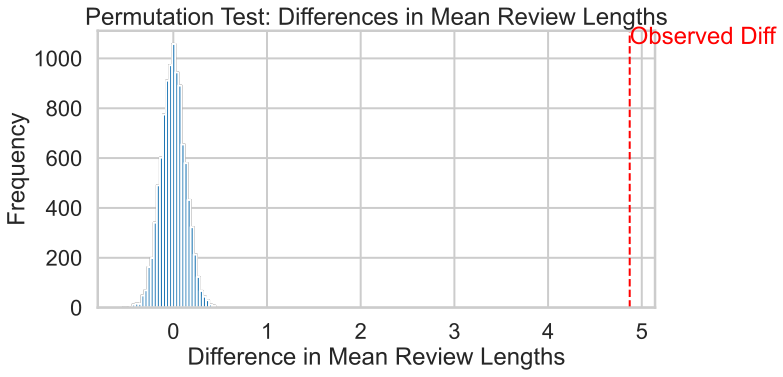

In [61]:
plt.hist(diffs, bins=30, alpha=0.75, color='blue', edgecolor='black')
plt.axvline(observed, color='red', linestyle='dashed', linewidth=2)
plt.title('Permutation Test: Differences in Mean Review Lengths')
plt.xlabel('Difference in Mean Review Lengths')
plt.ylabel('Frequency')
plt.text(observed, max(plt.hist(diffs, bins=30)[0]), 'Observed Diff', color='red')
plt.show()

## Step 5: Framing a Prediction Problem

In [62]:
# Our prediction problem is to predict the average rating of a recipe based on its nutritional content.
# This is a classification problem because we are using rating as an ordinal categorical variable.
# The features used to predict the average rating are derived from the 'nutrition' column from 
# the original dataframes, and include:
#     Total fat (PDV)
#     Sugar (PDV)
#     Sodium (PDV)
#     Protein (PDV)
#     Saturated fat (PDV)
#     Carbohydrates (PDV)
# These features were chosen as they represent key nutritional components that
# might influence user ratings based on health and taste considerations.
# We used two models for classifications: and decision tree classifier and a random forest classifier.
# We used accuracy as the primary evaluation metric to assess the performance of our classification models,
# and confusion matrices were used to understand musclassification patterns and evaluate model robustness.


## Step 6: Baseline Model

In [63]:
df = df.dropna(subset=['rating'])
X = df[['total fat (PDV)', 'sugar (PDV)', 'sodium (PDV)', 'protein (PDV)', 'saturated fat (PDV)', 'carbohydrates (PDV)']]
y = df['rating']

In [64]:
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

In [65]:
model = DecisionTreeClassifier()
pipeline = Pipeline([
    ('classifier', model)
])

pipeline.fit(X_train, y_train)
y_pred_val = pipeline.predict(X_val)
y_pred_train = pipeline.predict(X_train)
y_pred_test = pipeline.predict(X_test)
val_accuracy = accuracy_score(y_val, y_pred_val)
train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)
val_accuracy, train_accuracy, test_accuracy




(0.6821942159119396, 0.8737113989440498, 0.6827183846486929)

In [66]:
confusion_matrix(y_test, y_pred_test)

array([[   42,    17,    24,   103,   413],
       [   10,     9,    23,    84,   315],
       [   35,    26,    74,   314,  1032],
       [   95,    99,   305,  1686,  5221],
       [  345,   297,   864,  4300, 28146]])

## Step 7: Final Model

In [67]:
epsilon = 1e-7
X['sodium_prop'] = X['sodium (PDV)'] / (X.sum(axis=1) + epsilon)
X['protein_to_fat_ratio'] = X['protein (PDV)'] / (X['total fat (PDV)'] + epsilon)
X.isna().sum()

total fat (PDV)         0
sugar (PDV)             0
sodium (PDV)            0
protein (PDV)           0
saturated fat (PDV)     0
carbohydrates (PDV)     0
sodium_prop             0
protein_to_fat_ratio    0
dtype: int64

In [68]:
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

In [69]:
model = RandomForestClassifier()
pipeline = Pipeline([
    ('classifier', model)
])

pipeline.fit(X_train, y_train)
y_pred_val = pipeline.predict(X_val)
y_pred_train = pipeline.predict(X_train)
y_pred_test = pipeline.predict(X_test)
val_accuracy = accuracy_score(y_val, y_pred_val)
train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)
val_accuracy, train_accuracy, test_accuracy


(0.7404453155267896, 0.8737113989440498, 0.7424964105836505)

In [70]:
confusion_matrix(y_test, y_pred_test)

array([[   28,    10,    12,    38,   511],
       [    4,     2,     9,    35,   391],
       [   15,    12,    34,   160,  1260],
       [   32,    33,   100,   868,  6373],
       [  112,    94,   254,  1844, 31648]])

## Step 8: Fairness Analysis

In [71]:
# TODO
from sklearn.metrics import precision_score
df.columns
new = X_test
med_fat = new['total fat (PDV)'].median()
low_fat = new['total fat (PDV)']<med_fat
high_fat = new['total fat (PDV)']>=med_fat

ls_precision = precision_score(y_test[low_fat], y_pred_test[low_fat], average='macro')
hs_precision = precision_score(y_test[high_fat], y_pred_test[high_fat], average='macro')
actual_diff = ls_precision-hs_precision
actual_diff
#Null Hypothesis: Our model is fair. Its precision for recipes with low sodium and high sodium are roughly the same, and any differences are due to random chance.
#Alternative Hypothesis: Our model is unfair. Its precision for low sodium is lower than its precision for high sodium.
#Group X: total fat content lower than mean Group Y: total fat content higher than mean
#Eval metric: precision Test stat: low_group precision - high_group precision
#significance level  .05
med_fat
df.columns

Index(['name', 'minutes', 'contributor_id', 'submitted', 'tags', 'n_steps',
       'steps', 'description', 'ingredients', 'n_ingredients', 'user_id',
       'recipe_id', 'date', 'rating', 'review', 'average rating per recipe',
       'calories (#)', 'total fat (PDV)', 'sugar (PDV)', 'sodium (PDV)',
       'protein (PDV)', 'saturated fat (PDV)', 'carbohydrates (PDV)',
       'review_len', 'review_na'],
      dtype='object')

In [72]:
def perm_fairness(X_test, y_test, y_pred_test, feature, n_perm=1000):
    median_val = X_test[feature].median()
    low_group_mask = X_test[feature]<median_val
    high_group_mask = X_test[feature]>=median_val
    
    lg_precision = precision_score(y_test[low_group_mask], y_pred_test[low_group_mask], average='macro')
    hg_precision = precision_score(y_test[high_group_mask], y_pred_test[high_group_mask], average='macro')
    actual_diff = lg_precision - hg_precision
    
    perm_diffs = []
    combined_labels = np.concatenate([y_test, y_pred_test])
    n=len(y_test)
    for _ in range(n_perm):
        np.random.shuffle(combined_labels)
        perm_y_test = combined_labels[:n]
        perm_y_pred = combined_labels[n:]
        perm_lg_precision = precision_score(perm_y_test[low_group_mask], perm_y_pred[low_group_mask], average='macro')
        perm_hg_precision = precision_score(perm_y_test[high_group_mask], perm_y_pred[high_group_mask], average='macro')
        perm_diff = perm_lg_precision - perm_hg_precision
        perm_diffs.append(perm_diff)
    p_val = np.sum(np.abs(perm_diffs)>=np.abs(actual_diff))/n_perm
    return actual_diff, perm_diffs, p_val

actual_diff, perm_diffs, p_value = perm_fairness(X_test, y_test, y_pred_test, 'total fat (PDV)')

actual_diff, p_value
#With a an actual observed difference of -0.0049 and a p-value of 0.229>0.05, we fail to reject the null hypothesis, 
#and there is not enough evidence to claim that our model is unfair. The models precision for recipes with low total fat is not lower its precision for recipes with high sodium, and the situation where it did seem to be different was due to random chance.

(0.0002541564791397888, 0.946)

In [73]:
import plotly.graph_objects as go
import plotly.io as pio
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#plot for permutation test

fig = go.Figure()
fig.add_trace(go.Histogram(
    x=perm_diffs,
    nbinsx=30,
    marker_color='blue',
    opacity=0.75,
    name='Permuted Differences'
))
fig.add_shape(
    type='line',
    x0=actual_diff,
    y0=0,
    x1=actual_diff,
    y1=np.histogram(perm_diffs, bins=30)[0].max(),
    line=dict(color='red', width=2, dash='dash'),
    name=f'Actual Difference\n{actual_diff:.4f}'
)
fig.add_annotation(
    x=actual_diff,
    y=np.histogram(perm_diffs, bins=30)[0].max() / 2,
    text=f'Actual Difference\n{actual_diff:.4f}',
    showarrow=True,
    arrowhead=1
)

fig.update_layout(
    title='Permutation Test: Distribution of Precision Differences',
    xaxis_title='Precision Difference',
    yaxis_title='Frequency',
    legend_title='Legend',
    width=650,
    height=450
)
# pio.write_html(fig, file='assets/precision_difference_histogram1.html', include_plotlyjs='cdn')
fig.show()